Original length of sample data is 132008
2044 tests with Result, IPAddress, TotalScore = NaN dropped
Extra ip address dropped in 963 tests


<IPython.core.display.Javascript object>


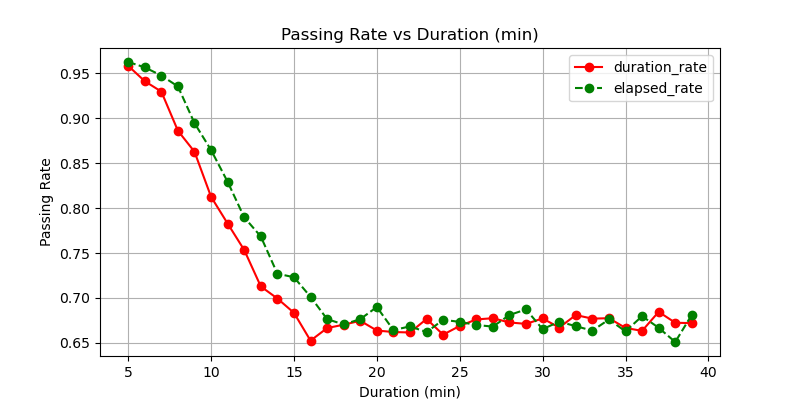

In [2]:
%matplotlib notebook
# Show variation of success vs time spent taking the driver's test.
# Add compare duration and elapsed time
# The success rate is averaged over bins of time taken to do the test.
# The bins are calculated by dividing the longest duration by some integer.
# See dmv_test/passing_rate.py

import dmv_test_input as dti
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import mplcursors
from itertools import cycle

def passing_rate(df, fields, limits):
    # passing_rate: DataFrame with columns duration and rate of passed tests 
    # input:
    #    df ...... dmv dataframe with columns duration and Result
    #    limits .. list of (upper, lower) bounds of duration intervals as produced 
    #              by function duration_intervals
    # DataFrame:
    #    duration ... lower bound of each interval
    #    rate ....... fraction of tests passed over total tests taken during the duration period
    
    def rate(lo, hi, df, field):
        # Calc passing rate inside this interval [lo, hi) of the field
        df["inside"] = (df[field] >= lo) & (df[field] < hi)
        n = df.inside.sum()
        if n == 0:
            return np.nan   # np.nan so it can be ignored later
        npassed = ( (df.inside) & (df.passed) ).sum()
        return npassed/n   
    def ncount(lo, hi, df, field):
        # Calc passing rate inside this interval [lo, hi) of the field
        df["inside"] = (df[field] >= lo) & (df[field] < hi)
        return df.inside.sum()
    def pcount(lo, hi, df, field):
        # Calc passing rate inside this interval [lo, hi) of the field
        df["inside"] = (df[field] >= lo) & (df[field] < hi) & (df.Result=='P')
        return df.inside.sum()
    
    pf = pd.DataFrame( { 'lo': [x[0] for x in limits], 'hi' : [x[1] for x in limits] } )
    pf['duration'] = pf.lo
    for field in fields:
        pf[field+'_rate'] = pf.apply(lambda x: rate(x.lo, x.hi, df, field), axis=1)
        pf['ncount'] = pf.apply(lambda x: ncount(x.lo, x.hi, df, field), axis=1)
        pf['pcount'] = pf.apply(lambda x: pcount(x.lo, x.hi, df, field), axis=1)
    
    return pf

def duration_intervals(lo=5., hi=100., inc=5.):
    r = np.arange(lo, hi+0.00001*(hi-lo)/inc, inc)
    return [ (r[i], r[i+1]) for i in range(len(r)-1) ] 

def plot_passing_rate(pf, fields):
    linestyle = cycle(["-", "--"])
    color = cycle(["red", "green"])
    fig, ax = plt.subplots(figsize=(8, 4))
    for field in fields:
        plt.plot(pf.duration, 
                 pf[field+"_rate"],  "o",
                 color=next(color),
                 linestyle=next(linestyle), 
                 label=field+"_rate")
    
    ax.set_title(f"Passing Rate vs Duration (min)")
    ax.set_xlabel(f"Duration (min)")
    ax.set_ylabel(f"Passing Rate")
    ax.legend()
    plt.grid(visible=True)
    plt.show() 

def main():

    df = dti.read_dmv_log(case=2)
    df["elapsed"] = abs(df['TestEndDateTime'] - df['TestStartDateTime']).dt.total_seconds()/60.
    df["passed"]  = (df.Result=="P")
    df = df[ (df.duration > 0) & (df.duration <= 40) & (df.elapsed > 0) & (df.elapsed < 60)].reset_index()
    
    limits = duration_intervals(lo=5, hi=40., inc=1.)
    
    test_times = ["duration", "elapsed"]
    
    pf = passing_rate(df, test_times, limits)
    
    #
    plot_passing_rate(pf, test_times)
    
    return df, pf

if __name__ == '__main__':
    df, pf = main()